In [66]:
import pandas as pd
import numpy as np
import random

from IPython.display import SVG, display
import xml.etree.ElementTree as ET
from matplotlib.colors import to_hex
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import PathPatch
from svgpath2mpl import parse_path
import xml.etree.ElementTree as ET

In [60]:
data_path = "/Users/abry4213/github/Homotopic_FC/data/"
subcortical_HoFC = pd.read_table(f"{data_path}/HCP_subctx_HoFC.txt", header=None)[0].values[0:7]

subcortical_paths_lookup = pd.read_csv("/Users/abry4213/Downloads/subcortical_paths_lookup.csv")

subcortical_HoFC_L_df = pd.DataFrame({"region": ["accumbens", "amygdala", "caudate", "hippocampus", "pallidum", "putamen", "thalamus"], 
                                       "value": subcortical_HoFC}).assign(Hemisphere = "L")
subcortical_HoFC_R_df = pd.DataFrame({"region": ["accumbens", "amygdala", "caudate", "hippocampus", "pallidum", "putamen", "thalamus"],
                                      "value": subcortical_HoFC}).assign(Hemisphere = "R")
subcortical_HoFC_df = pd.concat([subcortical_HoFC_L_df, subcortical_HoFC_R_df])

## Dummy data just to show the different regions

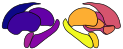

In [20]:
# Get 12 evenly spaced values from 0 to 1
values = [i / 11 for i in range(12)]  # 11 because range is inclusive at the top

# Get RGB colors from viridis
colors = [cm.plasma(v) for v in values]  # returns RGBA tuples

# If you want HEX codes instead:
hex_colors = [to_hex(c) for c in colors]

# Load SVG
tree = ET.parse("/Users/abry4213/Downloads/subcortex_base.svg")
root = tree.getroot()

# Define SVG namespace
ns = {'svg': 'http://www.w3.org/2000/svg'}
ET.register_namespace('', ns['svg'])  # Prevents adding ns0 in output

# Find objects
paths = root.findall('.//svg:path', ns)  # for example, all <path> elements

# Convert to string
import io
svg_io = io.BytesIO()

for path_num in range(len(paths)):
    path_fill = hex_colors[path_num]

    # Set style to no fill
    this_path = paths[path_num]
    style = this_path.attrib.get('style')
    if style:
        # Replace fill in the style string
        parts = style.split(';')
        new_parts = [p for p in parts if not p.strip().startswith('fill:')]
        new_parts.append(f'fill:{path_fill}')
        this_path.set('style', ';'.join(new_parts))
    else:
        this_path.set('fill', path_fill)

# Display in notebook
tree.write(svg_io, encoding='utf-8', xml_declaration=True)
svg_str = svg_io.getvalue().decode()
display(SVG(svg_str))

In [21]:
# Load SVG
base_SVG_file="/Users/abry4213/Downloads/subcortex_base.svg"
tree = ET.parse(base_SVG_file)
root = tree.getroot()

# Define SVG namespace
ns = {'svg': 'http://www.w3.org/2000/svg'}
ET.register_namespace('', ns['svg'])  # Prevents adding ns0 in output

# Find objects
paths = root.findall('.//svg:path', ns)  # for example, all <path> elements

# Convert to string
import io

# Merge example data with paths
example_subcortical_df_with_paths = subcortical_HoFC_df.merge(subcortical_paths_lookup, on=['region', 'Hemisphere'], how='left').sort_values('path_number')

# Extract fill values
fill_values = example_subcortical_df_with_paths['value'].values

In [67]:
def plot_subcortical_data(subcortex_data, subcortical_paths_lookup,
                          line_thickness=1.5, line_color='black',
                          hemisphere='L', fill_title = "values", cmap='viridis', 
                          vmin=None, vmax=None,):
    # Load SVG
    tree = ET.parse(f"/Users/abry4213/Downloads/subcortex_base_{hemisphere}.svg")
    root = tree.getroot()

    # Define SVG namespace
    ns = {'svg': 'http://www.w3.org/2000/svg'}
    ET.register_namespace('', ns['svg'])  # Prevents adding ns0 in output

    # Find objects
    paths = root.findall('.//svg:path', ns)  # for example, all <path> elements

    # If hemisphere = 'both', filter subcortical_paths_lookup to Num_Hemi == 2
    if hemisphere == 'both':
        subcortical_paths_lookup = subcortical_paths_lookup.query("Num_Hemi == 2")
        # Merge example data with paths
        subcortex_data_with_paths = (subcortex_data
                                            .merge(subcortical_paths_lookup, on=['region', 'Hemisphere'], how='left')
                                            .sort_values('path_number'))
    else:
        subcortical_paths_lookup = subcortical_paths_lookup.query("Num_Hemi == 1")
        # Merge example data with paths
        subcortex_data_with_paths = (subcortex_data
                                            .merge(subcortical_paths_lookup, on=['region', 'Hemisphere'], how='left')
                                            .query("Hemisphere == @hemisphere")
                                            .sort_values('path_number'))

    

    # Extract fill values
    fill_values = subcortex_data_with_paths['value'].values

    if vmin is None:
        vmin = np.min(fill_values)
    if vmax is None:
        vmax = np.max(fill_values)

    # Normalize values and set up colormap
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    if isinstance(cmap, str):
        cmap = matplotlib.colormaps.get_cmap(cmap)
        
    elif isinstance(cmap, mcolors.Colormap):
        pass

    # Start plotting
    fig, ax = plt.subplots(figsize=(6, 6))

    patches = []
    for path_elem, fill_value in zip(paths, fill_values):
        d = path_elem.attrib['d']
        path = parse_path(d)
        patch = PathPatch(path, facecolor=cmap(norm(fill_value)), edgecolor=line_color, lw=line_thickness)
        ax.add_patch(patch)
        patches.append(patch)

    # Set axis limits and aspect
    ax.autoscale_view()
    ax.set_aspect('equal')
    ax.axis('off')
    ax.invert_yaxis()  # <- This fixes the upside-down SVG

    # Add colorbar
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # required for colorbar to render
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label(fill_title)

    plt.tight_layout()
    plt.show()

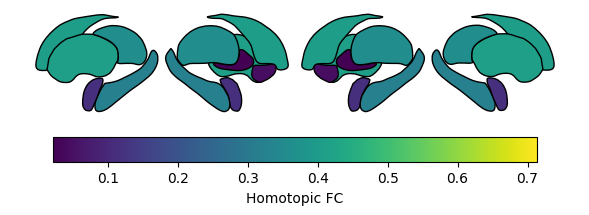

In [75]:
plot_subcortical_data(subcortical_HoFC_df, subcortical_paths_lookup, 
                      hemisphere="both", cmap='viridis',
                      fill_title = "Homotopic FC",
                      line_color='black', line_thickness=1,
                      vmin = 0.021, vmax=0.714)